## Animated surface plot y=f(x,z)

This example shows how to:
   - create a surface plot
   - animate updates of the plot data
   - optimize compute load

In [1]:
# use "notebook" option to display figure between cells
# in the browser window - heaviest to the CPU
%matplotlib notebook

# use "qt" option to open figure outside the browser, this
# reduces CPU load (less interface layers and image copies
# between the ray tracer and GUI display)
#%matplotlib qt

# TkOptiX GUI instead of matplotlib+NpOptix gives the best
# performance plus all GUI actions (rotations, focus, etc.);
# change import below and raytracer constructor name
# (indicated in the code)
#from plotoptix import TkOptiX
from plotoptix import NpOptiX

from plotoptix.utils import map_to_colors, simplex
from plotoptix.materials import m_eye_normal_cos

import matplotlib.pyplot as plt
import numpy as np

Make some data. The mesh size and simplex noise calculations are not very significant in this example. You can try much larger meshes.

In [2]:
class params():
    rx = (-1, 16); nx = 180
    rz = (0, 10); nz = 100

    x = np.linspace(rx[0], rx[1], nx)
    z = np.linspace(rz[0], rz[1], nz)

    X, Z = np.meshgrid(x, z)
    XZ = np.stack((X.flatten(), Z.flatten(), np.full(nx*nz, 1.0, dtype=np.float32))).T.reshape(nz, nx, 3)
    XZ = np.ascontiguousarray(XZ, dtype=np.float32)
    Y = simplex(XZ)

**Setup callback functions**

In [3]:
def init(rt):                # configure scene and plot data at initialization
    rt.set_param(
        min_accumulation_step=16,    # <- smooth out images, good for camera with depth
                                     #    of field simulation (DoF), affects GPU load
        max_accumulation_frames=50   # <- max number of frames to compute when paused
    )
    rt.setup_material("cos", m_eye_normal_cos) # setup a very fast-shaded material
                                               # (no secondary rays are calculated,
                                               # saves lots of GPU time)
        
    # standard gamma correction (2D postprocessing is almost for free on GPU)
    rt.set_float("tonemap_exposure", 0.8)
    rt.set_float("tonemap_gamma", 2.2)
    rt.add_postproc("Gamma")
    
    rt.set_background(0)
    rt.set_ambient(0.25)

    rt.set_data_2d("surface", params.Y,
                   range_x=params.rx, range_z=params.rz,
                   c=map_to_colors(params.Y, "OrRd"),
                   mat="cos",         # comment out to use default, diffuse material
                                      # (diffuse requires multiple secondary rays)
                   make_normals=True)

    rt.setup_camera("cam1",
                    cam_type="DoF",   # comment out to use default, pinhole camera
                                      # (pinhole has no DoF and requires very few
                                      # accumulaton frames, for anti-aliasing only)
                    eye=[7.5, 1.5, 18],
                    aperture_radius=0.2,
                    fov=20, focal_scale=0.62)
    
    rt.setup_light("light1", pos=[2,  5, 20], color=5, radius=4) # not used with m_eye_normal_cos

In [4]:
def compute(rt, delta):      # compute scene updates in parallel to the raytracing
    params.XZ += 0.03 * delta * np.array([-0.2, 1, 0.4], dtype=np.float32)
    params.Y = simplex(params.XZ, params.Y) # compute noise "in place"

In [5]:
def update_data(rt):         # update plot data (raytracing is finished here)
    rt.update_data_2d("surface",
                      pos=params.Y,
                      c=map_to_colors(params.Y, "OrRd"))

In [6]:
def update_image(rt):        # update your image here (not used with TkOptiX)
    imgplot.set_data(rt._img_rgba)
    plt.draw()

Prepare the output figure:

<IPython.core.display.Javascript object>


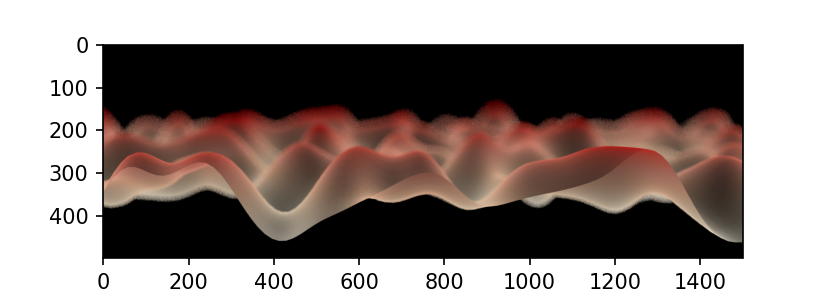

In [7]:
width = 1500; height = 500   # width*height ~ rays_to_trace, directly affects GPU load!

plt.figure(1, figsize=(5.5, 2))
plt.tight_layout()
imgplot = plt.imshow(np.zeros((height, width, 4), dtype=np.uint8))

In [8]:
optix = NpOptiX(                     # change to TkOptiX for the lowest CPU load
    on_initialization=init,
    on_scene_compute=compute,
    on_rt_completed=update_data,
    on_launch_finished=update_image, # comment out if TkOptiX is used
    width=width, height=height,
    start_now=True)

The `on_scene_compute` - `on_rt_completed` callbacks can be paused/resumed. Raytracing is still running, until the `max_accumulation_frames` is reached. You can run the two following cells multiple times and see how the image is smoothed out during pause.

In [9]:
optix.pause_compute()

In [10]:
optix.resume_compute()

Stop all (raytracing cannot be restarted from that point):

In [11]:
optix.close()